# LLM Benchmark Performance Analysis
This notebook provides comprehensive analysis of multiple LLM benchmark results, automatically detecting all result files in the results folder and comparing their performance across different metrics including scores, difficulty levels, categories, and price-to-performance ratios.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np
from pathlib import Path

# Configuration for pricing (add new models here)
PRICING_CONFIG = {
    'claude-3.5-sonnet' : 1.552,
    'claude-sonnet-4' : 6.640,
    'command-r7b-12-2024' : 0.014,
    'deepseek-v3': 0.189,
    'gemini-1.5-flash' : 0.025,
    'gemini-2.0-flash' : 0.062,
    'gemini-2.5-flash-preview': 0.136,
    'gemini-2.5-flash-preview-thinking': 2.108,
    'gemini-2.5-pro-preview' : 10.81,
    'gemma-3-12b-it' : 0.007,
    'gemma-3-27b-it' : 0.027,
    'grok-3-mini-beta' : 0.14,
    'mistral-nemo' : 0.007,
    'mistral-small-24b-instruct' : 0.018,
    'gpt-3.5-turbo' : 0.106,
    'gpt-4.1' : 0.994,
    'gpt-4.1-nano' : 0.043,
    'gpt-4o': 1.502,
    'gpt-4o-mini': 0.051,
    'grok-3-mini-beta' : 0.140,
    'llama-3.3-8b-instruct' : 0,
    'llama-3.3-70b-instruct' : 0.037,
    'llama-4-maverick' : 0.064,
    'o4-mini' : 0.939,
    # Add more models and their costs here as needed
    # 'model_name': cost_for_180_tasks
}

# Set up plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Function to clean and validate evaluation scores
def clean_evaluation_score(score):
    """
    Clean and validate evaluation scores, handling malformed data
    Replace any malformed data with 0 (failed task)
    """
    if pd.isna(score):
        return 0.0
    
    # Convert to string to handle various input types
    score_str = str(score).strip()
    
    # Handle empty strings
    if not score_str:
        return 0.0
    
    # Try to extract the first valid number if it's a concatenated string
    try:
        # First try direct conversion
        parsed_score = float(score_str)
        # Validate range (0-10), clip if outside
        return max(0.0, min(10.0, parsed_score))
    except ValueError:
        # If that fails, try to extract the first digit(s)
        import re
        # Look for the first number in the string (including decimals)
        match = re.search(r'^(\d+\.?\d*)', score_str)
        if match:
            try:
                parsed_score = float(match.group(1))
                # Validate range (0-10), clip if outside
                return max(0.0, min(10.0, parsed_score))
            except ValueError:
                pass
        
        # If all else fails, return 0 (treat as failed task)
        print(f"⚠️  Malformed score '{score_str[:50]}...' replaced with 0")
        return 0.0

# Function to load all result files
def load_all_results(results_dir='../results'):
    """
    Load all CSV result files from the results directory
    Returns a dictionary with model names as keys and DataFrames as values
    """
    results = {}
    
    # Find all CSV files in results directory
    csv_files = glob.glob(os.path.join(results_dir, '*_results.csv'))
    
    for file_path in csv_files:
        # Extract model name from filename
        filename = os.path.basename(file_path)
        model_name = filename.replace('_results.csv', '')
        
        try:
            df = pd.read_csv(file_path)
            
            # Data validation and cleaning
            original_count = len(df)
            
            # Clean evaluation scores
            if 'evaluation_score' in df.columns:
                print(f"🔧 Cleaning evaluation scores for {model_name}...")
                original_scores = df['evaluation_score'].copy()
                df['evaluation_score'] = df['evaluation_score'].apply(clean_evaluation_score)
                
                # Count how many were replaced with 0 due to malformation
                malformed_count = len(df[df['evaluation_score'] == 0]) - len(original_scores[original_scores == 0])
                if malformed_count > 0:
                    print(f"   ⚠️  Replaced {malformed_count} malformed scores with 0 (failed tasks)")
                
                # All scores should now be valid numbers (0-10)
                invalid_range = df[(df['evaluation_score'] < 0) | (df['evaluation_score'] > 10)]
                if len(invalid_range) > 0:
                    print(f"   ⚠️  Found and clipped {len(invalid_range)} scores outside 0-10 range")
            
            # Ensure we have the required columns
            required_columns = ['task_id', 'evaluation_score']
            missing_columns = [col for col in required_columns if col not in df.columns]
            if missing_columns:
                print(f"   ⚠️  Missing required columns: {missing_columns}")
                continue
            
            results[model_name] = df
            print(f"✓ Loaded {len(df)} valid tasks for {model_name} (from {original_count} total)")
            
        except Exception as e:
            print(f"✗ Error loading {filename}: {e}")
    
    print(f"\nTotal models loaded: {len(results)}")
    return results

# Load all results
all_results = load_all_results()

if not all_results:
    print("No result files found in the results directory!")
else:
    print("\nAvailable models:", list(all_results.keys()))

🔧 Cleaning evaluation scores for claude-3.5-sonnet...
✓ Loaded 180 valid tasks for claude-3.5-sonnet (from 180 total)
🔧 Cleaning evaluation scores for claude-sonnet-4...
✓ Loaded 180 valid tasks for claude-sonnet-4 (from 180 total)
🔧 Cleaning evaluation scores for command-r7b-12-2024...
✓ Loaded 180 valid tasks for command-r7b-12-2024 (from 180 total)
🔧 Cleaning evaluation scores for deepseek-v3...
⚠️  Malformed score 'Error...' replaced with 0
   ⚠️  Replaced 5 malformed scores with 0 (failed tasks)
✓ Loaded 180 valid tasks for deepseek-v3 (from 180 total)
🔧 Cleaning evaluation scores for gemini-1.5-flash...
✓ Loaded 180 valid tasks for gemini-1.5-flash (from 180 total)
🔧 Cleaning evaluation scores for gemini-2.0-flash...
✓ Loaded 180 valid tasks for gemini-2.0-flash (from 180 total)
🔧 Cleaning evaluation scores for gemini-2.5-flash-preview-thinking...
✓ Loaded 180 valid tasks for gemini-2.5-flash-preview-thinking (from 180 total)
🔧 Cleaning evaluation scores for gemini-2.5-flash-prev

## 1. Overview Statistics for All Models

In [238]:
# Calculate overview statistics for all models
def calculate_model_stats(model_name, df, pricing_config):
    """
    Calculate statistics for a single model with error handling
    """
    try:
        total_tasks = len(df)
        
        # Ensure evaluation_score is numeric
        if 'evaluation_score' not in df.columns:
            print(f"⚠️  No evaluation_score column found for {model_name}")
            return None
        
        # Convert to numeric, errors will become NaN
        scores = pd.to_numeric(df['evaluation_score'], errors='coerce')
        
        # Remove NaN values for calculations
        valid_scores = scores.dropna()
        
        if len(valid_scores) == 0:
            print(f"⚠️  No valid scores found for {model_name}")
            return None
        
        avg_score = valid_scores.mean()
        min_score = valid_scores.min()
        max_score = valid_scores.max()
        
        # Get pricing info
        price_total = pricing_config.get(model_name, 0)
        price_per_task = price_total / total_tasks if total_tasks > 0 else 0
        score_per_dollar = valid_scores.sum() / price_total if price_total > 0 else 0
        
        return {
            'model': model_name,
            'total_tasks': total_tasks,
            'valid_tasks': len(valid_scores),
            'avg_score': avg_score,
            'min_score': min_score,
            'max_score': max_score,
            'total_cost': price_total,
            'cost_per_task': price_per_task,
            'score_per_dollar': score_per_dollar
        }
    except Exception as e:
        print(f"⚠️  Error calculating stats for {model_name}: {e}")
        return None

# Create summary table
summary_stats = []
for model_name, df in all_results.items():
    stats = calculate_model_stats(model_name, df, PRICING_CONFIG)
    if stats is not None:  # Only add valid statistics
        summary_stats.append(stats)

# Convert to DataFrame for easy display
summary_df = pd.DataFrame(summary_stats)

print("=" * 80)
print("BENCHMARK SUMMARY STATISTICS")
print("=" * 80)

if len(summary_df) > 0:
    for _, row in summary_df.iterrows():
        print(f"\n📊 {row['model'].upper()}")
        print(f"   Total tasks: {row['total_tasks']}")
        if 'valid_tasks' in row and row['valid_tasks'] != row['total_tasks']:
            print(f"   Valid tasks: {row['valid_tasks']} (after cleaning)")
        print(f"   Average score: {row['avg_score']:.2f}")
        print(f"   Score range: {row['min_score']:.1f} – {row['max_score']:.1f}")
        if row['total_cost'] > 0:
            print(f"   Total cost: ${row['total_cost']:.3f}")
            print(f"   Cost per task: ${row['cost_per_task']:.4f}")
            print(f"   Score per dollar: {row['score_per_dollar']:.2f}")
        else:
            print(f"   ⚠️  No pricing data available")
else:
    print("⚠️  No valid data found for any models!")

print("\n" + "=" * 80)

BENCHMARK SUMMARY STATISTICS

📊 CLAUDE-3.5-SONNET
   Total tasks: 180
   Average score: 7.77
   Score range: 2.0 – 10.0
   Total cost: $1.552
   Cost per task: $0.0086
   Score per dollar: 901.42

📊 CLAUDE-SONNET-4
   Total tasks: 180
   Average score: 8.23
   Score range: 5.0 – 10.0
   Total cost: $6.640
   Cost per task: $0.0369
   Score per dollar: 223.04

📊 COMMAND-R7B-12-2024
   Total tasks: 180
   Average score: 6.44
   Score range: 0.0 – 10.0
   Total cost: $0.014
   Cost per task: $0.0001
   Score per dollar: 82857.14

📊 DEEPSEEK-V3
   Total tasks: 180
   Average score: 7.56
   Score range: 0.0 – 10.0
   Total cost: $0.189
   Cost per task: $0.0010
   Score per dollar: 7201.06

📊 GEMINI-1.5-FLASH
   Total tasks: 180
   Average score: 7.56
   Score range: 3.0 – 10.0
   ⚠️  No pricing data available

📊 GEMINI-2.0-FLASH
   Total tasks: 180
   Average score: 7.96
   Score range: 3.0 – 10.0
   Total cost: $0.062
   Cost per task: $0.0003
   Score per dollar: 23096.77

📊 GEMINI-2.5-F

## 2. Performance Comparison Across All Models

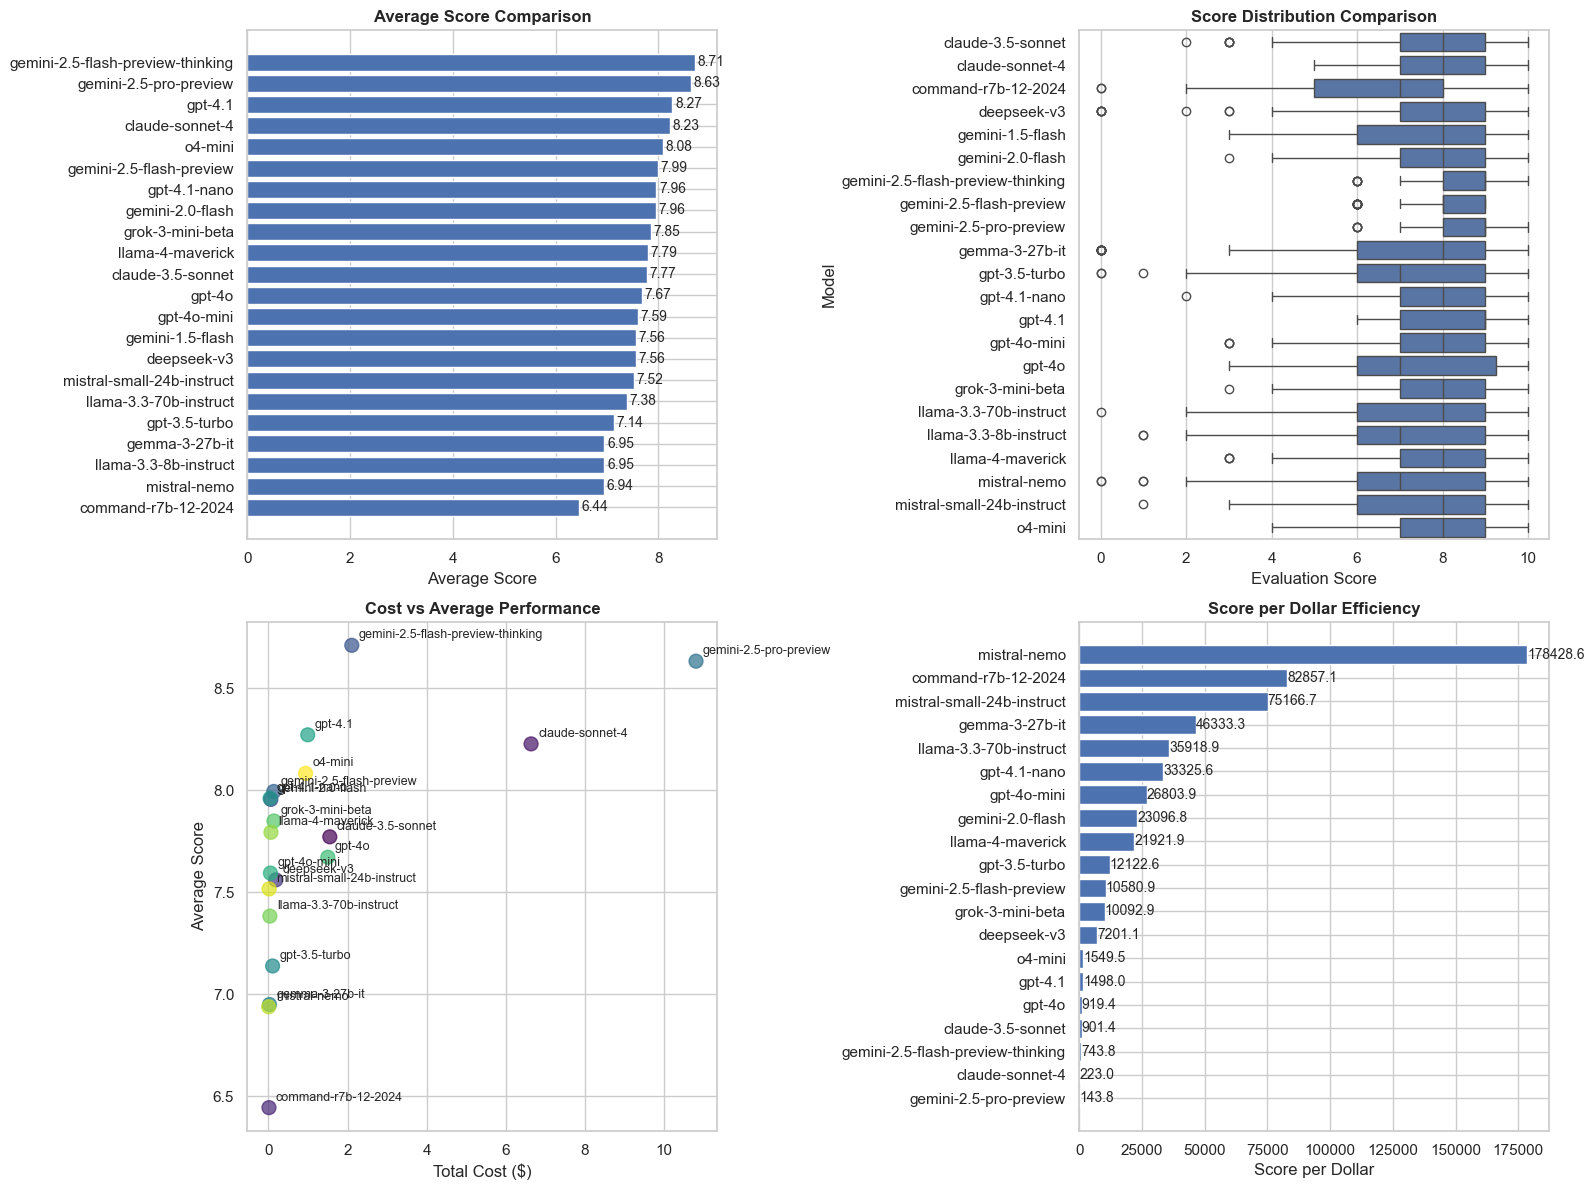

In [239]:
# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Average scores comparison
if summary_df is not None and len(summary_df) > 0:
    summary_df_sorted = summary_df.sort_values('avg_score', ascending=True)
    bars = axes[0,0].barh(summary_df_sorted['model'], summary_df_sorted['avg_score'])
    axes[0,0].set_title('Average Score Comparison', fontweight='bold')
    axes[0,0].set_xlabel('Average Score')
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, summary_df_sorted['avg_score'])):
        axes[0,0].text(score + 0.05, i, f'{score:.2f}', va='center')
else:
    axes[0,0].text(0.5, 0.5, 'No valid data available', 
                   transform=axes[0,0].transAxes, ha='center', va='center')
    axes[0,0].set_title('Average Score Comparison (No Data)', fontweight='bold')

# 2. Score distribution boxplot for all models
combined_data = []
for model_name, df in all_results.items():
    if 'evaluation_score' in df.columns:
        # Clean and convert scores
        scores = pd.to_numeric(df['evaluation_score'], errors='coerce')
        valid_scores = scores.dropna()
        
        if len(valid_scores) > 0:
            model_data = pd.DataFrame({
                'evaluation_score': valid_scores,
                'model': model_name
            })
            combined_data.append(model_data)

if combined_data:
    combined_df = pd.concat(combined_data, ignore_index=True)
    sns.boxplot(data=combined_df, y='model', x='evaluation_score', ax=axes[0,1])
    axes[0,1].set_title('Score Distribution Comparison', fontweight='bold')
    axes[0,1].set_xlabel('Evaluation Score')
    axes[0,1].set_ylabel('Model')
else:
    axes[0,1].text(0.5, 0.5, 'No valid score data available', 
                   transform=axes[0,1].transAxes, ha='center', va='center')
    axes[0,1].set_title('Score Distribution (No Data)', fontweight='bold')

# 3. Cost vs Performance (if pricing data available)
if len(summary_df) > 0:
    priced_models = summary_df[summary_df['total_cost'] > 0]
    if len(priced_models) > 0:
        scatter = axes[1,0].scatter(priced_models['total_cost'], priced_models['avg_score'], 
                                  s=100, alpha=0.7, c=range(len(priced_models)), cmap='viridis')
        axes[1,0].set_title('Cost vs Average Performance', fontweight='bold')
        axes[1,0].set_xlabel('Total Cost ($)')
        axes[1,0].set_ylabel('Average Score')
        
        # Add model labels
        for _, row in priced_models.iterrows():
            axes[1,0].annotate(row['model'], (row['total_cost'], row['avg_score']), 
                              xytext=(5, 5), textcoords='offset points', fontsize=9)
    else:
        axes[1,0].text(0.5, 0.5, 'No pricing data available', 
                       transform=axes[1,0].transAxes, ha='center', va='center')
        axes[1,0].set_title('Cost vs Performance (No Data)', fontweight='bold')
else:
    axes[1,0].text(0.5, 0.5, 'No valid data available', 
                   transform=axes[1,0].transAxes, ha='center', va='center')
    axes[1,0].set_title('Cost vs Performance (No Data)', fontweight='bold')

# 4. Score per dollar comparison
if len(summary_df) > 0:
    priced_models = summary_df[summary_df['total_cost'] > 0]
    if len(priced_models) > 0:
        priced_sorted = priced_models.sort_values('score_per_dollar', ascending=True)
        bars = axes[1,1].barh(priced_sorted['model'], priced_sorted['score_per_dollar'])
        axes[1,1].set_title('Score per Dollar Efficiency', fontweight='bold')
        axes[1,1].set_xlabel('Score per Dollar')
        
        # Add value labels
        for i, (bar, score) in enumerate(zip(bars, priced_sorted['score_per_dollar'])):
            axes[1,1].text(score + 0.5, i, f'{score:.1f}', va='center')
    else:
        axes[1,1].text(0.5, 0.5, 'No pricing data available', 
                       transform=axes[1,1].transAxes, ha='center', va='center')
        axes[1,1].set_title('Score per Dollar (No Data)', fontweight='bold')
else:
    axes[1,1].text(0.5, 0.5, 'No valid data available', 
                   transform=axes[1,1].transAxes, ha='center', va='center')
    axes[1,1].set_title('Score per Dollar (No Data)', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Performance by Difficulty Level

## 2.5. Task Success Rate Analysis

This section analyzes the distribution of task completion success based on evaluation scores:
- **Failed**: Score 0-5 
- **Incomplete**: Score 6-7
- **Successful**: Score 8-10

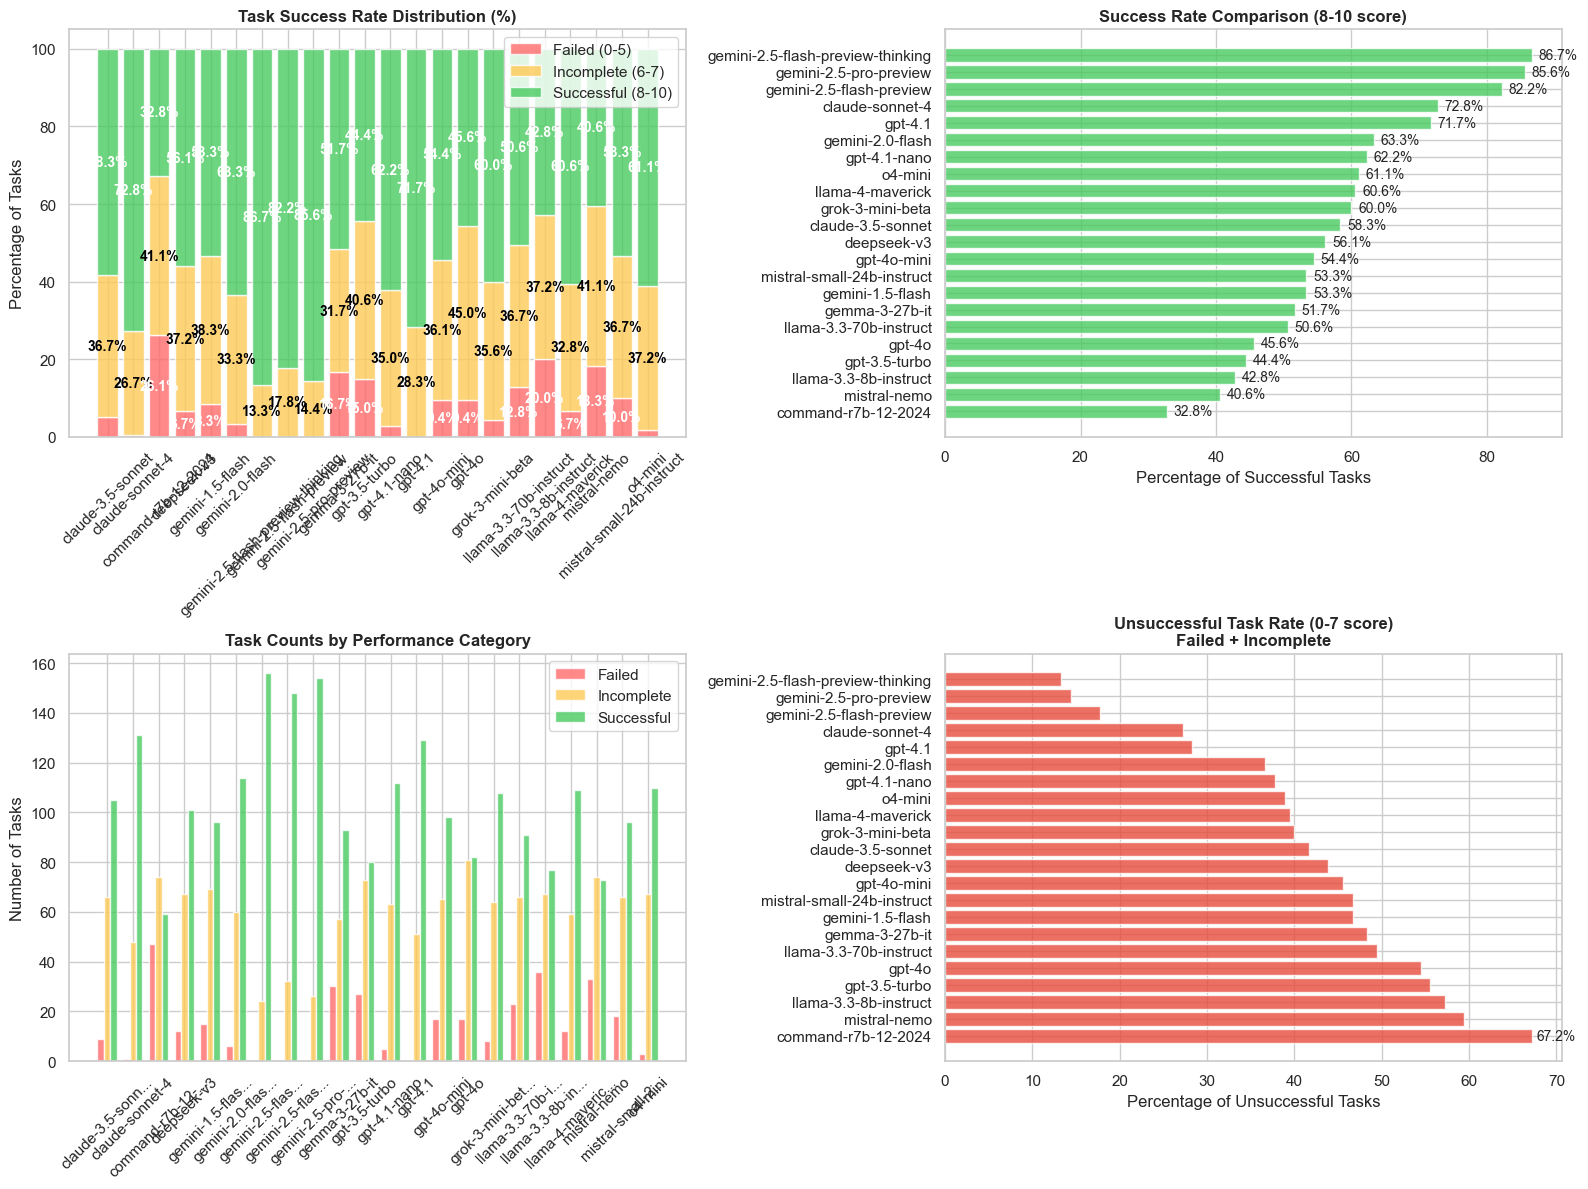


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

<Figure size 1200x800 with 0 Axes>


📈 TASK SUCCESS RATE ANALYSIS

🔸 CLAUDE-3.5-SONNET
   Total valid tasks: 180
   ✅ Successful (8-10): 105 tasks (58.3%)
   ⚠️  Incomplete (6-7): 66 tasks (36.7%)
   ❌ Failed (0-5): 9 tasks (5.0%)

🔸 CLAUDE-SONNET-4
   Total valid tasks: 180
   ✅ Successful (8-10): 131 tasks (72.8%)
   ⚠️  Incomplete (6-7): 48 tasks (26.7%)
   ❌ Failed (0-5): 1 tasks (0.6%)

🔸 COMMAND-R7B-12-2024
   Total valid tasks: 180
   ✅ Successful (8-10): 59 tasks (32.8%)
   ⚠️  Incomplete (6-7): 74 tasks (41.1%)
   ❌ Failed (0-5): 47 tasks (26.1%)

🔸 DEEPSEEK-V3
   Total valid tasks: 180
   ✅ Successful (8-10): 101 tasks (56.1%)
   ⚠️  Incomplete (6-7): 67 tasks (37.2%)
   ❌ Failed (0-5): 12 tasks (6.7%)

🔸 GEMINI-1.5-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 96 tasks (53.3%)
   ⚠️  Incomplete (6-7): 69 tasks (38.3%)
   ❌ Failed (0-5): 15 tasks (8.3%)

🔸 GEMINI-2.0-FLASH
   Total valid tasks: 180
   ✅ Successful (8-10): 114 tasks (63.3%)
   ⚠️  Incomplete (6-7): 60 tasks (33.3%)
   ❌ Failed (0-5): 6

In [240]:
# Task Success Rate Analysis
def categorize_task_performance(score):
    """Categorize task performance based on evaluation score"""
    if pd.isna(score):
        return 'Invalid'
    if score <= 5:
        return 'Failed (0-5)'
    elif score <= 7:
        return 'Incomplete (6-7)'
    else:
        return 'Successful (8-10)'

# Calculate success rates for each model
success_data = []
for model_name, df in all_results.items():
    if 'evaluation_score' not in df.columns:
        print(f"⚠️  Skipping {model_name}: no evaluation_score column")
        continue
    
    # Clean and convert scores
    df_copy = df.copy()
    df_copy['evaluation_score'] = pd.to_numeric(df_copy['evaluation_score'], errors='coerce')
    
    # Remove invalid scores for analysis
    df_valid = df_copy.dropna(subset=['evaluation_score'])
    
    if len(df_valid) == 0:
        print(f"⚠️  Skipping {model_name}: no valid scores")
        continue
    
    df_valid['performance_category'] = df_valid['evaluation_score'].apply(categorize_task_performance)
    
    # Count tasks in each category
    performance_counts = df_valid['performance_category'].value_counts()
    total_valid_tasks = len(df_valid)
    total_original_tasks = len(df_copy)
    
    # Calculate percentages
    failed_count = performance_counts.get('Failed (0-5)', 0)
    incomplete_count = performance_counts.get('Incomplete (6-7)', 0)
    successful_count = performance_counts.get('Successful (8-10)', 0)
    
    failed_pct = (failed_count / total_valid_tasks) * 100 if total_valid_tasks > 0 else 0
    incomplete_pct = (incomplete_count / total_valid_tasks) * 100 if total_valid_tasks > 0 else 0
    successful_pct = (successful_count / total_valid_tasks) * 100 if total_valid_tasks > 0 else 0
    
    success_data.append({
        'model': model_name,
        'failed_count': failed_count,
        'incomplete_count': incomplete_count,
        'successful_count': successful_count,
        'failed_pct': failed_pct,
        'incomplete_pct': incomplete_pct,
        'successful_pct': successful_pct,
        'total_valid_tasks': total_valid_tasks,
        'total_original_tasks': total_original_tasks
    })

success_df = pd.DataFrame(success_data)

# Only proceed if we have valid data
if len(success_df) == 0:
    print("⚠️  No valid success rate data found!")
else:
    # Create comprehensive success rate visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Stacked bar chart of success rates (percentages)
    models = success_df['model']
    failed_pcts = success_df['failed_pct']
    incomplete_pcts = success_df['incomplete_pct']
    successful_pcts = success_df['successful_pct']

    axes[0,0].bar(models, failed_pcts, label='Failed (0-5)', color='#ff6b6b', alpha=0.8)
    axes[0,0].bar(models, incomplete_pcts, bottom=failed_pcts, label='Incomplete (6-7)', color='#feca57', alpha=0.8)
    axes[0,0].bar(models, successful_pcts, bottom=failed_pcts + incomplete_pcts, label='Successful (8-10)', color='#48ca5f', alpha=0.8)

    axes[0,0].set_title('Task Success Rate Distribution (%)', fontweight='bold')
axes[0,0].set_ylabel('Percentage of Tasks')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Add percentage labels on bars
for i, model in enumerate(models):
    # Failed percentage
    if failed_pcts.iloc[i] > 5:  # Only show if > 5%
        axes[0,0].text(i, failed_pcts.iloc[i]/2, f'{failed_pcts.iloc[i]:.1f}%', 
                      ha='center', va='center', fontweight='bold', color='white')
    # Incomplete percentage
    if incomplete_pcts.iloc[i] > 5:
        axes[0,0].text(i, failed_pcts.iloc[i] + incomplete_pcts.iloc[i]/2, f'{incomplete_pcts.iloc[i]:.1f}%', 
                      ha='center', va='center', fontweight='bold', color='black')
    # Successful percentage
    if successful_pcts.iloc[i] > 5:
        axes[0,0].text(i, failed_pcts.iloc[i] + incomplete_pcts.iloc[i] + successful_pcts.iloc[i]/2, 
                      f'{successful_pcts.iloc[i]:.1f}%', ha='center', va='center', fontweight='bold', color='white')

# 2. Success rate comparison (successful tasks only)
success_df_sorted = success_df.sort_values('successful_pct', ascending=True)
bars = axes[0,1].barh(success_df_sorted['model'], success_df_sorted['successful_pct'], color='#48ca5f', alpha=0.8)
axes[0,1].set_title('Success Rate Comparison (8-10 score)', fontweight='bold')
axes[0,1].set_xlabel('Percentage of Successful Tasks')

# Add value labels
for i, (bar, pct) in enumerate(zip(bars, success_df_sorted['successful_pct'])):
    axes[0,1].text(pct + 1, i, f'{pct:.1f}%', va='center')

# 3. Absolute task counts
models_short = [model[:15] + '...' if len(model) > 15 else model for model in models]  # Shorten long names
x = range(len(models))
width = 0.25

axes[1,0].bar([i - width for i in x], success_df['failed_count'], width, label='Failed', color='#ff6b6b', alpha=0.8)
axes[1,0].bar(x, success_df['incomplete_count'], width, label='Incomplete', color='#feca57', alpha=0.8)
axes[1,0].bar([i + width for i in x], success_df['successful_count'], width, label='Successful', color='#48ca5f', alpha=0.8)

axes[1,0].set_title('Task Counts by Performance Category', fontweight='bold')
axes[1,0].set_ylabel('Number of Tasks')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models_short, rotation=45)
axes[1,0].legend()

# 4. Failure rate comparison (failed + incomplete tasks = unsuccessful)
# Calculate combined unsuccessful rate (failed + incomplete)
success_df['unsuccessful_pct'] = success_df['failed_pct'] + success_df['incomplete_pct']
unsuccessful_df_sorted = success_df.sort_values('unsuccessful_pct', ascending=False)
bars = axes[1,1].barh(unsuccessful_df_sorted['model'], unsuccessful_df_sorted['unsuccessful_pct'], color='#e74c3c', alpha=0.8)
axes[1,1].set_title('Unsuccessful Task Rate (0-7 score)\nFailed + Incomplete', fontweight='bold')
axes[1,1].set_xlabel('Percentage of Unsuccessful Tasks')

# Add value labels
for i, (bar, pct) in enumerate(zip(bars, unsuccessful_df_sorted['unsuccessful_pct'])):
    axes[1,1].text(pct + 0.5, i, f'{pct:.1f}%', va='center')

    plt.tight_layout()
    plt.show()

    # Print detailed success rate statistics
    print("\n📈 TASK SUCCESS RATE ANALYSIS")
    print("=" * 60)

    for _, row in success_df.iterrows():
        print(f"\n🔸 {row['model'].upper()}")
        print(f"   Total valid tasks: {row['total_valid_tasks']}")
        if row['total_original_tasks'] != row['total_valid_tasks']:
            print(f"   Original tasks: {row['total_original_tasks']} (some had invalid scores)")
        print(f"   ✅ Successful (8-10): {row['successful_count']} tasks ({row['successful_pct']:.1f}%)")
        print(f"   ⚠️  Incomplete (6-7): {row['incomplete_count']} tasks ({row['incomplete_pct']:.1f}%)")
        print(f"   ❌ Failed (0-5): {row['failed_count']} tasks ({row['failed_pct']:.1f}%)")

    # Success rate rankings
    print("\n🏆 SUCCESS RATE RANKINGS:")
    print("-" * 40)
    success_ranked = success_df.sort_values('successful_pct', ascending=False)
    for i, (_, row) in enumerate(success_ranked.iterrows(), 1):
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "📍"
        print(f"{emoji} {i}. {row['model']}: {row['successful_pct']:.1f}% success rate")
        print(f"     ({row['successful_count']}/{row['total_valid_tasks']} tasks)")

    print("\n💥 UNSUCCESSFUL TASK RATE RANKINGS (Failed + Incomplete):")
    print("-" * 50)
    unsuccessful_ranked = success_df.sort_values('unsuccessful_pct', ascending=False)
    for i, (_, row) in enumerate(unsuccessful_ranked.iterrows(), 1):
        emoji = "⚠️" if i == 1 else "📍"
        unsuccessful_count = row['failed_count'] + row['incomplete_count']
        print(f"{emoji} {i}. {row['model']}: {row['unsuccessful_pct']:.1f}% unsuccessful rate")
        print(f"     ({unsuccessful_count}/{row['total_valid_tasks']} tasks: {row['failed_count']} failed + {row['incomplete_count']} incomplete)")

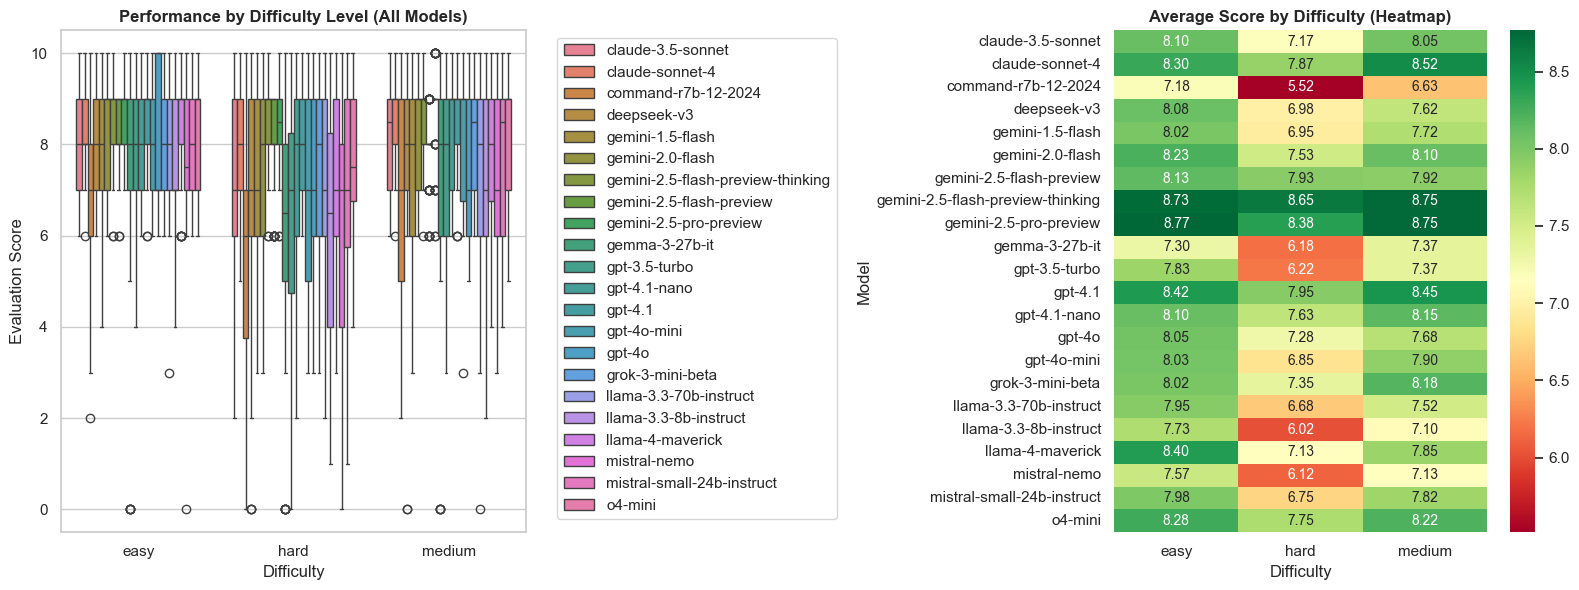


📈 PERFORMANCE BY DIFFICULTY LEVEL

CLAUDE-3.5-SONNET:
  easy: 8.10 avg (n=60)
  hard: 7.17 avg (n=60)
  medium: 8.05 avg (n=60)

CLAUDE-SONNET-4:
  easy: 8.30 avg (n=60)
  hard: 7.87 avg (n=60)
  medium: 8.52 avg (n=60)

COMMAND-R7B-12-2024:
  easy: 7.18 avg (n=60)
  hard: 5.52 avg (n=60)
  medium: 6.63 avg (n=60)

DEEPSEEK-V3:
  easy: 8.08 avg (n=60)
  hard: 6.98 avg (n=60)
  medium: 7.62 avg (n=60)

GEMINI-1.5-FLASH:
  easy: 8.02 avg (n=60)
  hard: 6.95 avg (n=60)
  medium: 7.72 avg (n=60)

GEMINI-2.0-FLASH:
  easy: 8.23 avg (n=60)
  hard: 7.53 avg (n=60)
  medium: 8.10 avg (n=60)

GEMINI-2.5-FLASH-PREVIEW-THINKING:
  easy: 8.73 avg (n=60)
  hard: 8.65 avg (n=60)
  medium: 8.75 avg (n=60)

GEMINI-2.5-FLASH-PREVIEW:
  easy: 8.13 avg (n=60)
  hard: 7.93 avg (n=60)
  medium: 7.92 avg (n=60)

GEMINI-2.5-PRO-PREVIEW:
  easy: 8.77 avg (n=60)
  hard: 8.38 avg (n=60)
  medium: 8.75 avg (n=60)

GEMMA-3-27B-IT:
  easy: 7.30 avg (n=60)
  hard: 6.18 avg (n=60)
  medium: 7.37 avg (n=60)

GPT-3.5

In [241]:
# Analyze performance by difficulty level
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create combined dataset with difficulty info
difficulty_data = []
for model_name, df in all_results.items():
    if 'difficulty' in df.columns and 'evaluation_score' in df.columns:
        # Clean data
        df_clean = df.copy()
        df_clean['evaluation_score'] = pd.to_numeric(df_clean['evaluation_score'], errors='coerce')
        df_clean = df_clean.dropna(subset=['evaluation_score', 'difficulty'])
        
        if len(df_clean) > 0:
            model_diff_data = df_clean[['evaluation_score', 'difficulty']].copy()
            model_diff_data['model'] = model_name
            difficulty_data.append(model_diff_data)

if difficulty_data:
    difficulty_df = pd.concat(difficulty_data, ignore_index=True)
    
    # 1. Boxplot by difficulty for all models
    sns.boxplot(data=difficulty_df, x='difficulty', y='evaluation_score', hue='model', ax=axes[0])
    axes[0].set_title('Performance by Difficulty Level (All Models)', fontweight='bold')
    axes[0].set_xlabel('Difficulty')
    axes[0].set_ylabel('Evaluation Score')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. Average performance by difficulty (heatmap style)
    diff_pivot = difficulty_df.groupby(['model', 'difficulty'])['evaluation_score'].mean().unstack(fill_value=0)
    sns.heatmap(diff_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[1])
    axes[1].set_title('Average Score by Difficulty (Heatmap)', fontweight='bold')
    axes[1].set_xlabel('Difficulty')
    axes[1].set_ylabel('Model')
else:
    axes[0].text(0.5, 0.5, 'No difficulty data available', 
                transform=axes[0].transAxes, ha='center', va='center')
    axes[1].text(0.5, 0.5, 'No difficulty data available', 
                transform=axes[1].transAxes, ha='center', va='center')

plt.tight_layout()
plt.show()

# Print difficulty statistics
if difficulty_data:
    print("\n📈 PERFORMANCE BY DIFFICULTY LEVEL")
    print("=" * 50)
    
    difficulty_stats = difficulty_df.groupby(['model', 'difficulty'])['evaluation_score'].agg(['mean', 'count']).round(2)
    
    for model in difficulty_df['model'].unique():
        print(f"\n{model.upper()}:")
        model_stats = difficulty_stats.loc[model]
        for difficulty in model_stats.index:
            mean_score = model_stats.loc[difficulty, 'mean']
            count = model_stats.loc[difficulty, 'count']
            print(f"  {difficulty}: {mean_score:.2f} avg (n={count})")

## 4. Performance by Category

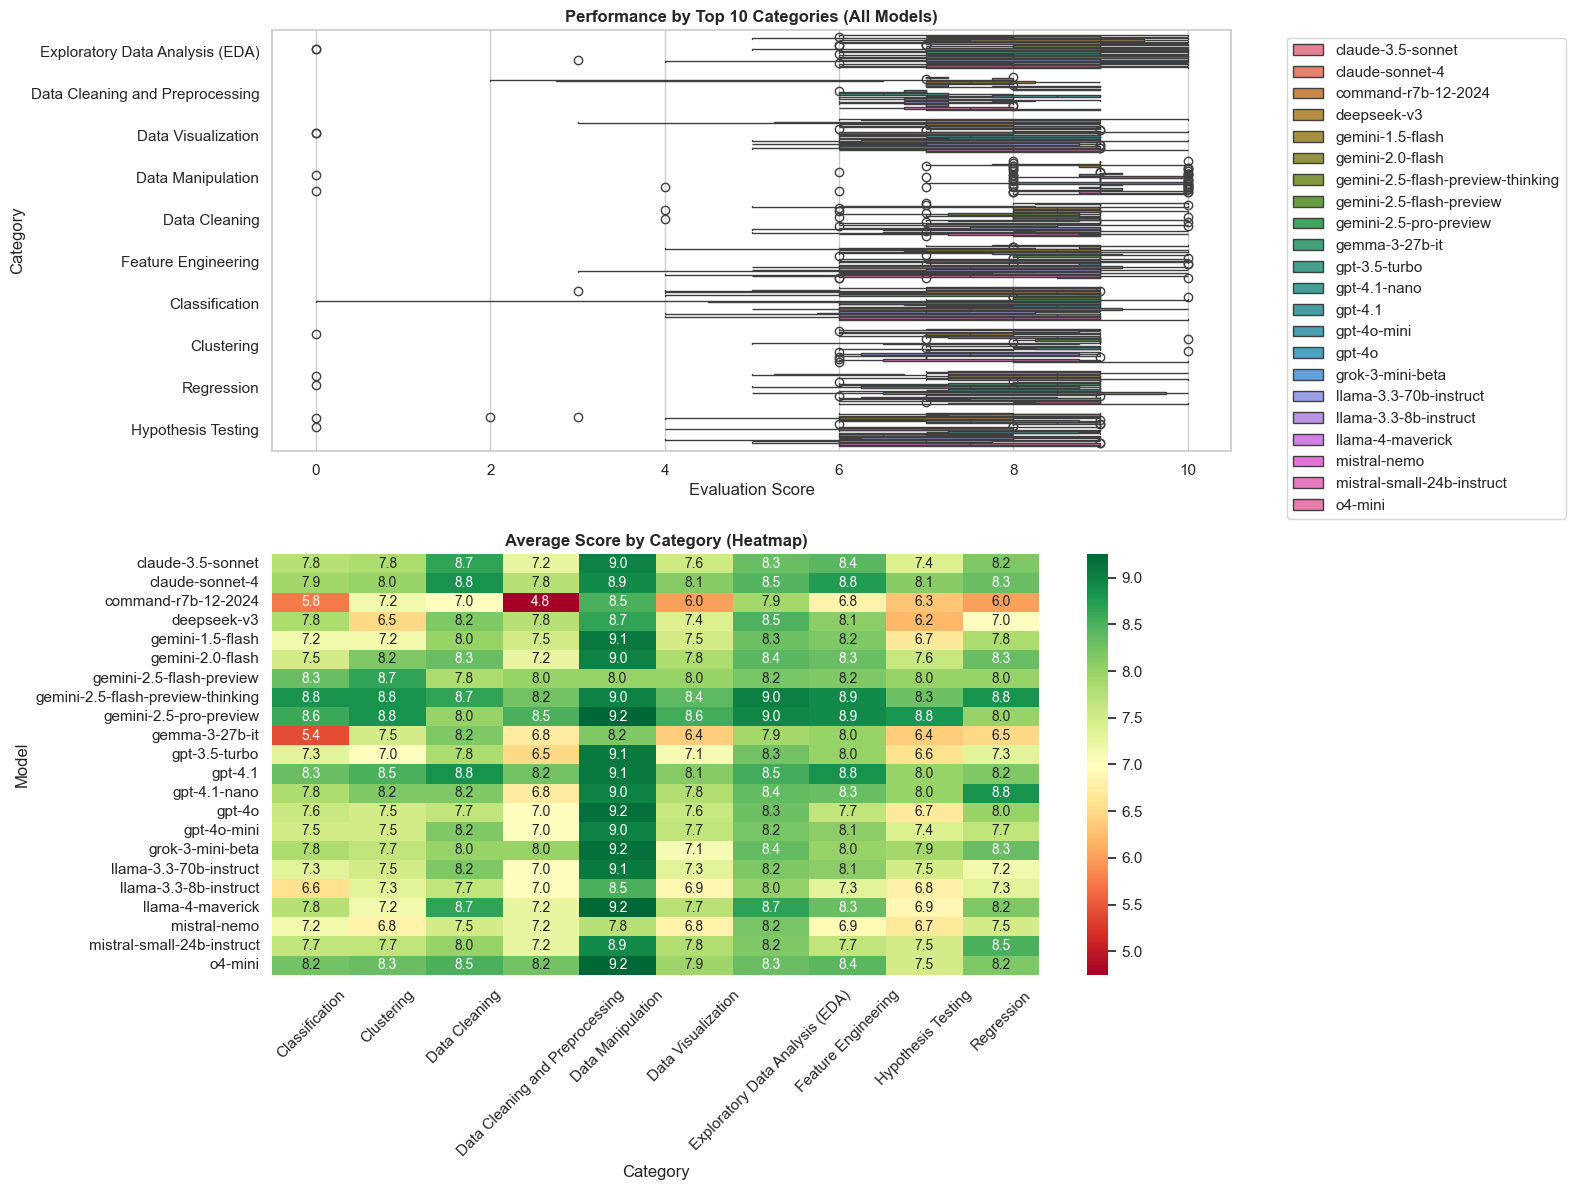


📂 PERFORMANCE BY CATEGORY

EXPLORATORY DATA ANALYSIS (EDA):
  gemini-2.5-flash-preview-thinking: 9.03
  gemini-2.5-pro-preview: 8.97
  llama-4-maverick: 8.68
  gpt-4.1: 8.55
  deepseek-v3: 8.48
  claude-sonnet-4: 8.45
  gemini-2.0-flash: 8.42
  grok-3-mini-beta: 8.35
  gpt-4.1-nano: 8.35
  claude-3.5-sonnet: 8.32
  o4-mini: 8.32
  gpt-4o: 8.29
  gemini-1.5-flash: 8.29
  gpt-3.5-turbo: 8.26
  gemini-2.5-flash-preview: 8.23
  gpt-4o-mini: 8.23
  mistral-nemo: 8.23
  llama-3.3-70b-instruct: 8.19
  mistral-small-24b-instruct: 8.16
  llama-3.3-8b-instruct: 8.03
  gemma-3-27b-it: 7.90
  command-r7b-12-2024: 7.90

DATA VISUALIZATION:
  gemini-2.5-pro-preview: 8.56
  gemini-2.5-flash-preview-thinking: 8.39
  gpt-4.1: 8.11
  claude-sonnet-4: 8.11
  gemini-2.5-flash-preview: 8.00
  o4-mini: 7.94
  gemini-2.0-flash: 7.83
  gpt-4.1-nano: 7.78
  mistral-small-24b-instruct: 7.78
  llama-4-maverick: 7.72
  gpt-4o-mini: 7.67
  gpt-4o: 7.61
  claude-3.5-sonnet: 7.56
  gemini-1.5-flash: 7.50
  deepseek

In [242]:
# Analyze performance by category
# Get top categories across all models
all_categories = []
for model_name, df in all_results.items():
    if 'category' in df.columns:
        all_categories.extend(df['category'].tolist())

if all_categories:
    top_categories = pd.Series(all_categories).value_counts().head(10).index.tolist()
    
    # Create category comparison
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # 1. Performance by top categories
    category_data = []
    for model_name, df in all_results.items():
        if 'category' in df.columns and 'evaluation_score' in df.columns:
            # Clean data
            df_clean = df.copy()
            df_clean['evaluation_score'] = pd.to_numeric(df_clean['evaluation_score'], errors='coerce')
            df_clean = df_clean.dropna(subset=['evaluation_score', 'category'])
            
            # Filter for top categories
            model_cat_data = df_clean[df_clean['category'].isin(top_categories)][['evaluation_score', 'category']].copy()
            if len(model_cat_data) > 0:
                model_cat_data['model'] = model_name
                category_data.append(model_cat_data)
    
    if category_data:
        category_df = pd.concat(category_data, ignore_index=True)
        
        sns.boxplot(data=category_df, y='category', x='evaluation_score', hue='model', ax=axes[0])
        axes[0].set_title('Performance by Top 10 Categories (All Models)', fontweight='bold')
        axes[0].set_xlabel('Evaluation Score')
        axes[0].set_ylabel('Category')
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 2. Category performance heatmap
        cat_pivot = category_df.groupby(['model', 'category'])['evaluation_score'].mean().unstack(fill_value=0)
        sns.heatmap(cat_pivot, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[1])
        axes[1].set_title('Average Score by Category (Heatmap)', fontweight='bold')
        axes[1].set_xlabel('Category')
        axes[1].set_ylabel('Model')
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print category statistics
        print("\n📂 PERFORMANCE BY CATEGORY")
        print("=" * 50)
        
        for category in top_categories[:5]:  # Show top 5 categories
            print(f"\n{category.upper()}:")
            cat_scores = category_df[category_df['category'] == category].groupby('model')['evaluation_score'].mean().sort_values(ascending=False)
            for model, score in cat_scores.items():
                print(f"  {model}: {score:.2f}")
    else:
        print("No valid category data available after cleaning.")
else:
    print("No category data available in the results.")

---
# Gemini 2.5 Flash Preview 5/20 Benchmark Performance Analysis
This section provides analysis of Gemini 2.5 Flash Preview 5/20 results.

## 5. Dynamic Price-to-Performance Analysis (All Models)

This section analyzes the price-to-performance relationship for all models with available pricing data.

Analyzing price-to-performance for 20 models with pricing data...

💰 PRICE-TO-PERFORMANCE RANKINGS
1. mistral-nemo: 178428.57 score per dollar
   (Avg: 6.94, Cost: $0.007)
2. command-r7b-12-2024: 82857.14 score per dollar
   (Avg: 6.44, Cost: $0.014)
3. mistral-small-24b-instruct: 75166.67 score per dollar
   (Avg: 7.52, Cost: $0.018)
4. gemma-3-27b-it: 46333.33 score per dollar
   (Avg: 6.95, Cost: $0.027)
5. llama-3.3-70b-instruct: 35918.92 score per dollar
   (Avg: 7.38, Cost: $0.037)
6. gpt-4.1-nano: 33325.58 score per dollar
   (Avg: 7.96, Cost: $0.043)
7. gpt-4o-mini: 26803.92 score per dollar
   (Avg: 7.59, Cost: $0.051)
8. gemini-2.0-flash: 23096.77 score per dollar
   (Avg: 7.96, Cost: $0.062)
9. llama-4-maverick: 21921.88 score per dollar
   (Avg: 7.79, Cost: $0.064)
10. gpt-3.5-turbo: 12122.64 score per dollar
   (Avg: 7.14, Cost: $0.106)
11. gemini-2.5-flash-preview: 10580.88 score per dollar
   (Avg: 7.99, Cost: $0.136)
12. grok-3-mini-beta: 10092.86 score per dollar
   (A

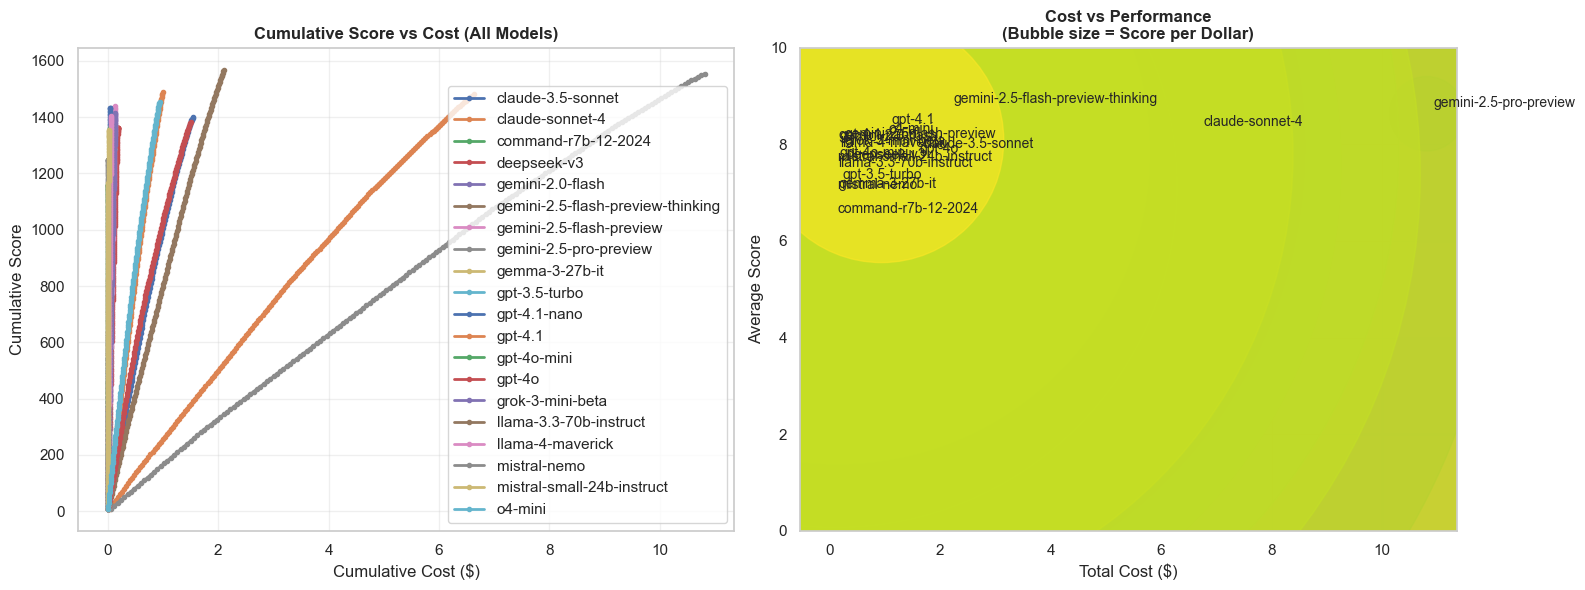

In [243]:
# Dynamic Price-to-Performance Analysis for All Models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get models with pricing data
priced_models_data = {}
for model_name, df in all_results.items():
    if model_name in PRICING_CONFIG and PRICING_CONFIG[model_name] > 0:
        priced_models_data[model_name] = df

if priced_models_data:
    print(f"Analyzing price-to-performance for {len(priced_models_data)} models with pricing data...\n")
    
    # 1. Cumulative score vs cumulative cost
    for model_name, df in priced_models_data.items():
        price_total = PRICING_CONFIG[model_name]
        price_per_task = price_total / len(df)
        
        df_sorted = df.sort_values('evaluation_score', ascending=False).reset_index(drop=True)
        df_sorted['cumulative_score'] = df_sorted['evaluation_score'].cumsum()
        df_sorted['cumulative_cost'] = [(i+1) * price_per_task for i in df_sorted.index]
        
        axes[0].plot(df_sorted['cumulative_cost'], df_sorted['cumulative_score'], 
                    marker='o', label=model_name, linewidth=2, markersize=3)
    
    axes[0].set_xlabel('Cumulative Cost ($)')
    axes[0].set_ylabel('Cumulative Score')
    axes[0].set_title('Cumulative Score vs Cost (All Models)', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Efficiency metrics bubble chart
    efficiency_data = []
    for model_name in priced_models_data.keys():
        stats = calculate_model_stats(model_name, all_results[model_name], PRICING_CONFIG)
        efficiency_data.append({
            'model': model_name,
            'score_per_dollar': stats['score_per_dollar'],
            'avg_score': stats['avg_score'],
            'total_cost': stats['total_cost']
        })
    
    eff_df = pd.DataFrame(efficiency_data)
    
    # Bubble chart: x=cost, y=avg_score, size=score_per_dollar
    scatter = axes[1].scatter(eff_df['total_cost'], eff_df['avg_score'], 
                             s=eff_df['score_per_dollar']*20, alpha=0.6, 
                             c=range(len(eff_df)), cmap='viridis')
    
    # Add model labels
    for _, row in eff_df.iterrows():
        axes[1].annotate(row['model'], (row['total_cost'], row['avg_score']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    axes[1].set_xlabel('Total Cost ($)')
    axes[1].set_ylabel('Average Score')
    axes[1].set_title('Cost vs Performance\n(Bubble size = Score per Dollar)', fontweight='bold')
    axes[1].set_ylim(0, 10)  # Set y-axis range from 0 to 10 for better score visualization
    axes[1].grid(True, alpha=0.3)
    
    # Print efficiency rankings
    print("💰 PRICE-TO-PERFORMANCE RANKINGS")
    print("=" * 40)
    eff_ranked = eff_df.sort_values('score_per_dollar', ascending=False)
    for i, (_, row) in enumerate(eff_ranked.iterrows(), 1):
        print(f"{i}. {row['model']}: {row['score_per_dollar']:.2f} score per dollar")
        print(f"   (Avg: {row['avg_score']:.2f}, Cost: ${row['total_cost']:.3f})")
        
else:
    axes[0].text(0.5, 0.5, 'No pricing data available for comparison\nAdd costs to PRICING_CONFIG', 
                transform=axes[0].transAxes, ha='center', va='center', fontsize=12)
    axes[1].text(0.5, 0.5, 'Add pricing data to PRICING_CONFIG\nto enable cost analysis', 
                transform=axes[1].transAxes, ha='center', va='center', fontsize=12)
    axes[0].set_title('Price-to-Performance Analysis (No Data)')
    axes[1].set_title('Cost Efficiency Analysis (No Data)')
    print("⚠️  No pricing data available. Add model costs to PRICING_CONFIG dictionary.")

plt.tight_layout()
plt.show()

## 6. Final Summary and Recommendations

🎯 COMPREHENSIVE BENCHMARK ANALYSIS SUMMARY

📊 OVERALL PERFORMANCE RANKING (by average score):
--------------------------------------------------
🥇 1. gemini-2.5-flash-preview-thinking - 8.71 avg score
     Range: 6.0 to 10.0
🥈 2. gemini-2.5-pro-preview - 8.63 avg score
     Range: 6.0 to 10.0
🥉 3. gpt-4.1 - 8.27 avg score
     Range: 6.0 to 10.0
📍 4. claude-sonnet-4 - 8.23 avg score
     Range: 5.0 to 10.0
📍 5. o4-mini - 8.08 avg score
     Range: 4.0 to 10.0
📍 6. gemini-2.5-flash-preview - 7.99 avg score
     Range: 6.0 to 9.0
📍 7. gpt-4.1-nano - 7.96 avg score
     Range: 2.0 to 10.0
📍 8. gemini-2.0-flash - 7.96 avg score
     Range: 3.0 to 10.0
📍 9. grok-3-mini-beta - 7.85 avg score
     Range: 3.0 to 10.0
📍 10. llama-4-maverick - 7.79 avg score
     Range: 3.0 to 10.0
📍 11. claude-3.5-sonnet - 7.77 avg score
     Range: 2.0 to 10.0
📍 12. gpt-4o - 7.67 avg score
     Range: 3.0 to 10.0
📍 13. gpt-4o-mini - 7.59 avg score
     Range: 3.0 to 10.0
📍 14. gemini-1.5-flash - 7.56 avg score

KeyError: "None of [Index(['LLM', 'Overall Score', 'Total Cost ($)', 'Average Time (s)'], dtype='object')] are in the [columns]"